In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# Get the project root directory (assuming you're in notebooks/)
PROJECT_ROOT = Path.cwd().parent  # or Path(__file__).parent.parent

# Read your data
train_df = pd.read_csv(PROJECT_ROOT / "data" / "train.csv")
test_df = pd.read_csv(PROJECT_ROOT / "data" / "test.csv")

In [2]:
train_df['date'] = pd.to_datetime(train_df['date'])

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        230130 non-null  int64         
 1   date      230130 non-null  datetime64[ns]
 2   country   230130 non-null  object        
 3   store     230130 non-null  object        
 4   product   230130 non-null  object        
 5   num_sold  221259 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 10.5+ MB


In [4]:
train_df.shape

(230130, 6)

In [5]:
train_df.size

1380780

In [6]:
train_df.describe()

,id,date,num_sold
count,230130.000000,230130,221259.000000
mean,115064.500000,2013-07-02 00:00:00,752.527382
min,0.000000,2010-01-01 00:00:00,5.000000
25%,57532.250000,2011-10-02 00:00:00,219.000000
50%,115064.500000,2013-07-02 00:00:00,605.000000
75%,172596.750000,2015-04-02 00:00:00,1114.000000
max,230129.000000,2016-12-31 00:00:00,5939.000000
std,66432.953062,NaN,690.165445


In [7]:
train_df.head(10)

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0
6,6,2010-01-01,Canada,Stickers for Less,Kaggle,1837.0
7,7,2010-01-01,Canada,Stickers for Less,Kaggle Tiers,1659.0
8,8,2010-01-01,Canada,Stickers for Less,Kerneler,807.0
9,9,2010-01-01,Canada,Stickers for Less,Kerneler Dark Mode,940.0


In [8]:
train_df.nunique()

id          230130
date          2557
country          6
store            3
product          5
num_sold      4037
dtype: int64

In [9]:
train_df.isna().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

In [10]:
train_df.groupby('country').count()

,id,date,store,product,num_sold
country,,,,,
Canada,38355,38355,38355,38355,34109
Finland,38355,38355,38355,38355,38355
Italy,38355,38355,38355,38355,38355
Kenya,38355,38355,38355,38355,33730
Norway,38355,38355,38355,38355,38355
Singapore,38355,38355,38355,38355,38355


In [11]:
train_df.groupby('store').count()

,id,date,country,product,num_sold
store,,,,,
Discount Stickers,76710,76710,76710,76710,71531
Premium Sticker Mart,76710,76710,76710,76710,75684
Stickers for Less,76710,76710,76710,76710,74044


In [12]:
train_df.groupby('product').count()

,id,date,country,store,num_sold
product,,,,,
Holographic Goose,46026,46026,46026,46026,37220
Kaggle,46026,46026,46026,46026,46026
Kaggle Tiers,46026,46026,46026,46026,46026
Kerneler,46026,46026,46026,46026,45962
Kerneler Dark Mode,46026,46026,46026,46026,46025


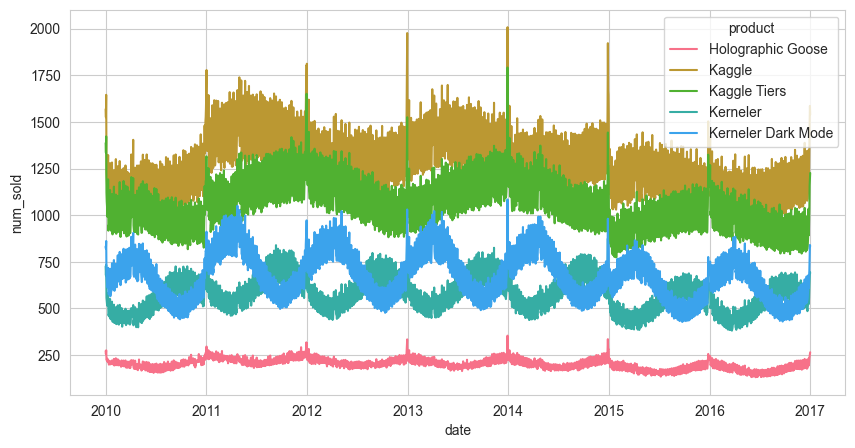

In [13]:
sns.set_style("whitegrid")
sns.set_palette("husl")

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='date', y='num_sold', data=train_df, hue='product', errorbar=None)
plt.show()

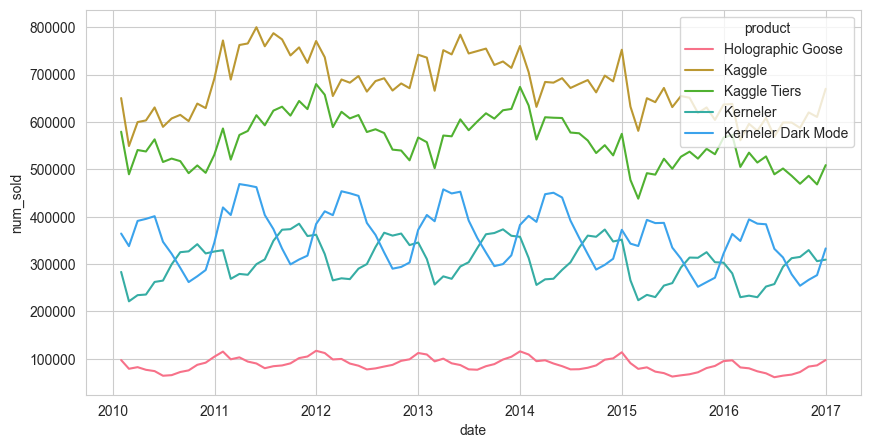

In [14]:
train_m_df = train_df.groupby([pd.Grouper(key='date', freq='ME'), 'product'])['num_sold'].sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='date', y='num_sold', data=train_m_df, hue='product', errorbar=None)
plt.show()

### Training pipeline

In [22]:
from loguru import logger

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

def impute_sales_values(df, group_data, group_name):
    """
    Impute missing sales values for a specific group
    """
    country, store, product = group_name
    y = group_data['num_sold'].values
    
    if np.isnan(y).any():
        y = pd.Series(y).ffill().to_numpy()
    
    if np.isnan(y).any():
        y = pd.Series(y).bfill().to_numpy()
    
    if np.isnan(y).any():
        avg_sales = df[
            (df['country'] == country) & 
            (df['product'] == product)
        ].groupby('date').mean('num_sold')['num_sold']
        
        y = avg_sales.ffill().bfill().to_numpy()
    
    return y

def train_models(train_df):
    """
    Train linear regression models for each group
    """
    grouped = train_df.groupby(['country', 'store', 'product'])
    models = {}
    train_predictions = {}

    for group_name, group_data in grouped:
        X = np.arange(len(group_data.index)).reshape(-1, 1)
        y = group_data['num_sold'].values
        
        model = LinearRegression()
        model.fit(X, y)
        
        y_pred_train = model.predict(X)
        train_mape = mean_absolute_percentage_error(y, y_pred_train) * 100
        
        models[group_name] = {
            'coefficient': model.coef_[0],
            'intercept': model.intercept_,
            'train_mape': train_mape,
            'model': model
        }
        
        train_predictions[group_name] = y_pred_train
    
    return models, train_predictions

train_df_processed = train_df.copy()
grouped = train_df_processed.groupby(['country', 'store', 'product'])
for group_name, group_data in grouped:
    mask = (
        (train_df_processed['country'] == group_name[0]) & 
        (train_df_processed['store'] == group_name[1]) & 
        (train_df_processed['product'] == group_name[2])
    )
    train_df_processed.loc[mask, 'num_sold'] = impute_sales_values(
        train_df_processed, 
        group_data, 
        group_name
    )

models, train_predictions = train_models(train_df_processed)

def predict_test_data(test_df, models):
    """
    Generate predictions for test data using trained models
    No actuals available in test data
    """
    test_predictions_df = test_df.copy()
    test_predictions_df['num_sold'] = np.nan
    
    for group_name, model_info in models.items():
        country, store, product = group_name
        
        mask = (
            (test_predictions_df['country'] == country) & 
            (test_predictions_df['store'] == store) & 
            (test_predictions_df['product'] == product)
        )
        test_group_data = test_predictions_df[mask]
        
        if len(test_group_data) > 0:
            X_test = np.arange(len(test_group_data.index)).reshape(-1, 1)
            y_pred_test = model_info['model'].predict(X_test)
            test_predictions_df.loc[mask, 'num_sold'] = y_pred_test
    
    return test_predictions_df

train_mapes = [model_info['train_mape'] for model_info in models.values()]
print(f"Average Training MAPE: {np.mean(train_mapes):.2f}%")
print(f"Min Training MAPE: {np.min(train_mapes):.2f}%")
print(f"Max Training MAPE: {np.max(train_mapes):.2f}%")

Average Training MAPE: 12.43%
Min Training MAPE: 6.31%
Max Training MAPE: 18.31%


In [23]:
# When ready for test predictions:
test_predictions_df = predict_test_data(test_df, models)

In [29]:
data_dir

'/Users/folkert/kaggle/data'

In [30]:
parent_dir

'/Users/folkert/kaggle'

In [32]:
os.path.dirname(os.path.abspath('.'))

'/Users/folkert/kaggle/playground_s05e01_forecasting_sticker_sales'

In [35]:
import os

test_predictions_df[['id', 'num_sold']].to_csv(os.path.dirname(os.path.abspath('.')) + '/data/' + 'submission.csv', index=False)

In [ ]:
df = train_df[train_df['product'] == "Kaggle"].copy()
df_product = df.groupby('date').sum('num_sold').reset_index()
df_product['Time'] = np.arange(len(df_product.index))
df_product

<Axes: xlabel='date', ylabel='num_sold'>

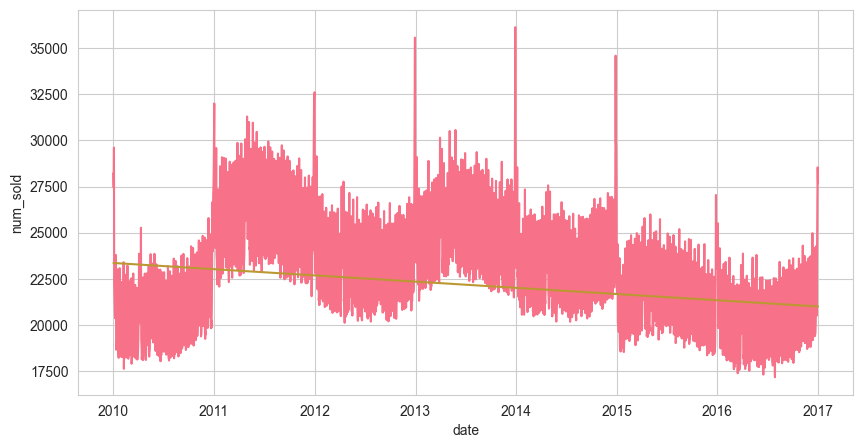

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='date', y='num_sold', data=df_product)
sns.lineplot(x='date', y='predicted', data=df_product)

In [ ]:
# Implement MAPE